In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from scipy.spatial import KDTree
import imageio
import os
from scipy.signal import find_peaks
import seaborn as sns
from scipy.stats import kruskal

In [2]:
# ZAŁADOWANIE DANYCH

file=pd.read_csv("single-cell-tracks_exp1-6_noErbB2.csv.gz",compression='gzip')
metadata=pd.read_csv("01-readme-experiment-description_2022-04-05.csv")

In [3]:
# łĄCZENIE DANYCH, ABY UWZGLĘDNIĆ MUTACJE

file = file.merge(metadata[['Site', 'Mutation']], left_on='Image_Metadata_Site', right_on='Site', how='left')
file = file.drop(columns=['Site'])
print(file.head())

   Exp_ID  Image_Metadata_Site  track_id  Image_Metadata_T  Nuclear_size  \
0       1                    1         1                 0       303.000   
1       1                    1         1                 1       333.000   
2       1                    1         1                 2       314.000   
3       1                    1         1                 3       322.000   
4       1                    1         1                 4       313.999   

   ERKKTR_ratio  FoxO3A_ratio  objNuclei_Location_Center_X  \
0      0.704407       1.33383                      932.211   
1      0.848242       1.33791                      932.150   
2      1.059170       1.37627                      932.376   
3      1.188000       1.35754                      932.168   
4      1.205540       1.36695                      931.146   

   objNuclei_Location_Center_Y Mutation  
0                      875.248       WT  
1                      874.174       WT  
2                      873.787       WT  
3 

### ZADANIE 1

In [4]:
# ZNAJDOWANIE ŚREDNICH I ODCHYLEŃ STANDARDOWYCH DLA KAŻDEJ MUTACJI I CZASU

# Grupowanie po czasie i mutacji
grouped = file.groupby(['Mutation', 'Image_Metadata_T'])

# Średnie i odchylenie
summary = grouped.agg({
    'ERKKTR_ratio': ['mean', 'std'],
    'FoxO3A_ratio': ['mean', 'std']
}).reset_index()


# Poprawienie nazw kolumn
summary.columns = ['Mutation', 'Time', 'ERK_mean', 'ERK_std', 'AKT_mean', 'AKT_std']


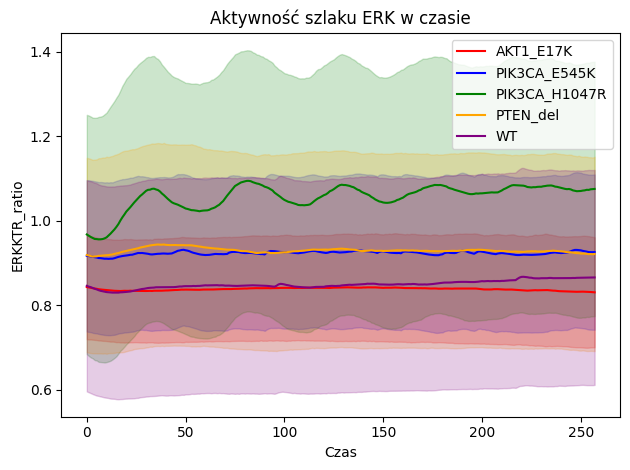

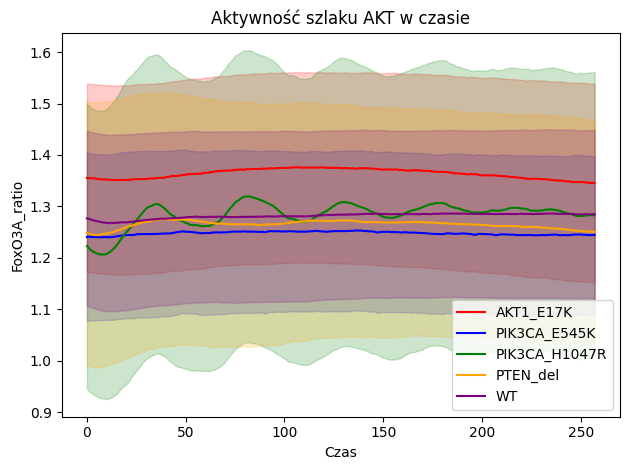

In [5]:
# WYKRESY AKTYWNOŚCI SZLAKÓW ERK I AKT W CZASIE

mutacje = summary['Mutation'].unique()
colors = ['red', 'blue', 'green', 'orange', 'purple']

for szlak in ['ERK', 'AKT']:
    for i, mut in enumerate(mutacje):

        # Filtracja danych dla konkretnej mutacji i rysowanie wykresu wraz z odchyleniem standardowym
        data = summary[summary['Mutation'] == mut]
        plt.plot(data['Time'], data[f'{szlak}_mean'], label=mut, color=colors[i])
        plt.fill_between(data['Time'],
                            data[f'{szlak}_mean'] - data[f'{szlak}_std'],
                            data[f'{szlak}_mean'] + data[f'{szlak}_std'],
                            alpha=0.2, color=colors[i])
    plt.title(f'Aktywność szlaku {szlak} w czasie')
    plt.xlabel('Czas')

    if szlak == 'ERK':
        plt.ylabel('ERKKTR_ratio')
    if szlak == 'AKT':
        plt.ylabel('FoxO3A_ratio')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
# TEST MANN-WHITNEYA DLA MUTACJI W CZASIE 60-180

# Przedział czasowy 60-180
summary_time = summary[(summary['Time'] >= 60) & (summary['Time'] <= 180)]

mutacje_WT = [m for m in mutacje if m != 'WT']  # pomijamy WT jako bazę

wyniki = []

for szlak, kolumna in [('ERK', 'ERK_mean'), ('AKT', 'AKT_mean')]:
    grupa_wt = summary_time[summary_time['Mutation'] == 'WT'][kolumna]

    for mut in mutacje_WT:
        
        grupa_mut = summary_time[summary_time['Mutation'] == mut][kolumna]

        # Test Manna-Whitneya
        stat, p = mannwhitneyu(grupa_mut, grupa_wt, alternative='two-sided')

        # Porównanie średnich aktywności w celu określenia zmiany
        srednia_wt = grupa_wt.mean()
        srednia_mut = grupa_mut.mean()
        
        if srednia_mut > srednia_wt:
            zmiana = "wzrost"
        elif srednia_mut < srednia_wt:
            zmiana = "spadek"
        else:
            zmiana = "brak zmiany"

        wyniki.append({'Mutacja': mut, 'Szlak': szlak, 'p_raw': p, 'U': stat, 'Zmiana': zmiana})

# Do DataFrame
wyniki_df = pd.DataFrame(wyniki)

# Korekcja wielokrotnych porównań (Bonferroni)
p_skorygowane = multipletests(wyniki_df['p_raw'], method='bonferroni')[1]
wyniki_df['p_bonferroni'] = p_skorygowane
wyniki_df['Istotne (α=0.05)'] = wyniki_df['p_bonferroni'] < 0.05

print(wyniki_df)

# ZAPIS WYNIKÓW DO CSV
wyniki_df.to_csv('wyniki_testu_mann_whitneya.csv', index=False)

         Mutacja Szlak         p_raw        U  Zmiana  p_bonferroni  \
0      AKT1_E17K   ERK  1.246652e-40     53.0  spadek  9.973214e-40   
1   PIK3CA_E545K   ERK  3.360344e-41  14641.0  wzrost  2.688275e-40   
2  PIK3CA_H1047R   ERK  3.360344e-41  14641.0  wzrost  2.688275e-40   
3       PTEN_del   ERK  3.360344e-41  14641.0  wzrost  2.688275e-40   
4      AKT1_E17K   AKT  3.360344e-41  14641.0  wzrost  2.688275e-40   
5   PIK3CA_E545K   AKT  3.360344e-41      0.0  spadek  2.688275e-40   
6  PIK3CA_H1047R   AKT  4.667843e-07  10065.0  wzrost  3.734275e-06   
7       PTEN_del   AKT  3.360344e-41      0.0  spadek  2.688275e-40   

   Istotne (α=0.05)  
0              True  
1              True  
2              True  
3              True  
4              True  
5              True  
6              True  
7              True  


### ZADANIE 2

wybrany wskaźnik to ERKKTR_ratio

In [6]:
# ZNAJDOWANIE PIKÓW I KOMÓREK AKTYWNYCH

results = []

for (exp, site, cell_id), sub in file.groupby(['Exp_ID', 'Image_Metadata_Site', 'track_id']):
    sub = sub.copy()
    signal = sub['ERKKTR_ratio'].values
    prog = np.quantile(signal, 0.9)

    # Indeksy lokalnych maksimów powyżej progu
    peaks, _ = find_peaks(signal, height=prog)
    
    is_active = np.zeros(len(sub), dtype=bool)

    # Zaznaczenie aktywnych pików
    is_peak= np.zeros(len(sub), dtype=bool)
    is_peak[peaks] = True
    sub['Is_peak'] = is_peak

    # Rozszerzenie aktywność o +2 i -2 wokół każdego indeksu
    for peak in peaks:
        start = max(0, peak - 2)
        end = min(len(sub), peak + 3)

        # Sprawdź, czy sąsiednie wartości są powyżej progu
        for i in range(start, end):
            if signal[i] > prog:
                is_active[i] = True

    sub['Is_active'] = is_active
    results.append(sub)

file = pd.concat(results, ignore_index=True)
print(file.head())

   Exp_ID  Image_Metadata_Site  track_id  Image_Metadata_T  Nuclear_size  \
0       1                    1         1                 0       303.000   
1       1                    1         1                 1       333.000   
2       1                    1         1                 2       314.000   
3       1                    1         1                 3       322.000   
4       1                    1         1                 4       313.999   

   ERKKTR_ratio  FoxO3A_ratio  objNuclei_Location_Center_X  \
0      0.704407       1.33383                      932.211   
1      0.848242       1.33791                      932.150   
2      1.059170       1.37627                      932.376   
3      1.188000       1.35754                      932.168   
4      1.205540       1.36695                      931.146   

   objNuclei_Location_Center_Y Mutation  Is_peak  Is_active  
0                      875.248       WT    False      False  
1                      874.174       WT    Fal

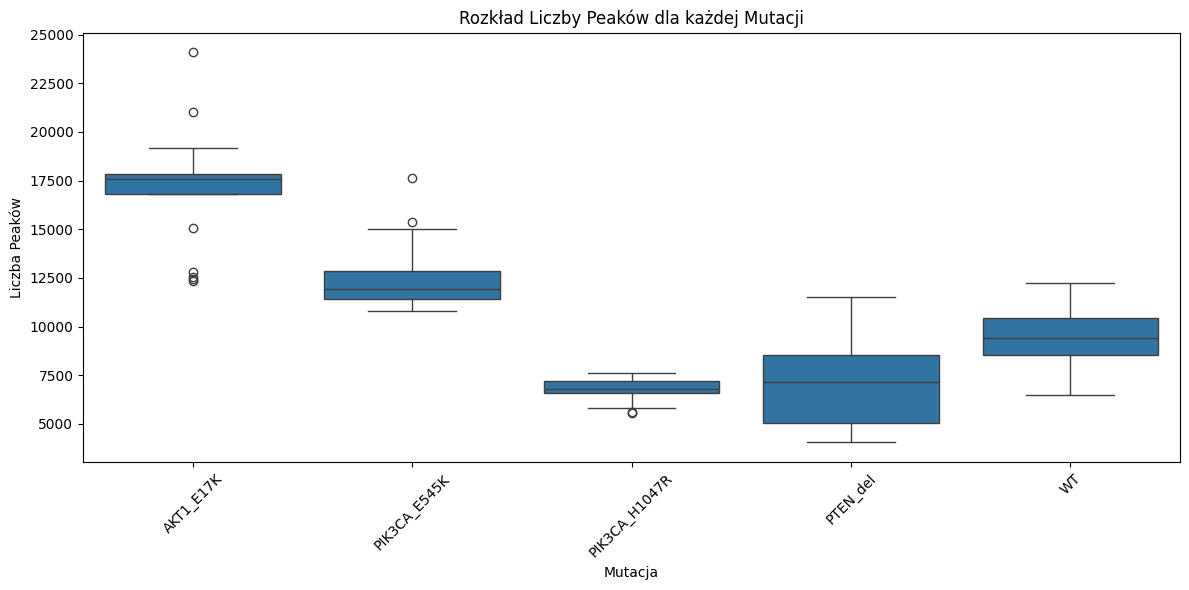

In [7]:
# LICZBA PIKÓW DLA KAŻDEJ MUTACJI

grouped_peak_counts = file.groupby(['Mutation', 'Exp_ID', 'Image_Metadata_Site'])['Is_peak'].sum().reset_index(name='Number_of_Peaks')

# Boxploty liczby peaków dla każdej mutacji
plt.figure(figsize=(12, 6))
sns.boxplot(x='Mutation', y='Number_of_Peaks', data=grouped_peak_counts)
plt.title('Rozkład Liczby Peaków dla każdej Mutacji')
plt.xlabel('Mutacja')
plt.ylabel('Liczba Peaków')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# KDTREE
# OBLICZENIE LICZBY AKTYWNYCH SĄSIADÓW I ŚREDNIEJ ERKKTR W PROMIENIU

results = []

for (exp, site, timepoint), sub in file.groupby(['Exp_ID', 'Image_Metadata_Site', 'Image_Metadata_T']):
    sub = sub.copy()
    coords = sub[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
    active = sub['Is_active'].values

    ERKKTR = sub['ERKKTR_ratio'].values

    # Sprawdzenie, czy jest wystarczająca liczba współrzędnych
    if len(coords) < 2:
        continue

    tree = KDTree(coords)

    # Znalezienie najbliższego sąsiada (k=2 to odległość euklidesowa)
    distances, _ = tree.query(coords, k=2)  

    # Pierwsza kolumna to odległość do samego siebie (0), bierzemy drugą
    nearest_distances = distances[:, 1]  

    # Obliczenie średniej i odchylenia standardowego
    mean_distance = np.mean(nearest_distances)
    std_distance = np.std(nearest_distances)

    # Ustalenie, że sąsiedzi są jeśli znajdują się w odległości średnia + odchylenie standardowe
    promien = mean_distance + std_distance

    liczba_aktywnych_sasiadow = []

    sasiedzi_ERKKTR_mean = []
    sasiedzi_ERKKTR_std = []
    

    for i, coord in enumerate(coords):
        idxs = tree.query_ball_point(coord, promien)

        # Obliczenie liczby aktywnych sąsiadów w promieniu, wykluczając siebie
        aktywni_sasiedzi = sum(active[j] for j in idxs if j != i)
        liczba_aktywnych_sasiadow.append(aktywni_sasiedzi)

        # Obliczenie średniej ERKKTR (bardziej do zadania 3)
        sasiedzi_komorki_ERKKTR = [ERKKTR[j] for j in idxs] # siebie uzględniamy
        sasiedzi_ERKKTR_mean.append(np.mean(sasiedzi_komorki_ERKKTR))
        sasiedzi_ERKKTR_std.append(np.std(sasiedzi_komorki_ERKKTR))


    sub['Active_Neighbours'] = liczba_aktywnych_sasiadow
    sub['Neighbours_ERKKTR_mean'] = sasiedzi_ERKKTR_mean
    sub['Neighbours_ERKKTR_std'] = sasiedzi_ERKKTR_std
    results.append(sub)

file = pd.concat(results)
file=file.sort_index()

print(file.head())

   Exp_ID  Image_Metadata_Site  track_id  Image_Metadata_T  Nuclear_size  \
0       1                    1         1                 0       303.000   
1       1                    1         1                 1       333.000   
2       1                    1         1                 2       314.000   
3       1                    1         1                 3       322.000   
4       1                    1         1                 4       313.999   

   ERKKTR_ratio  FoxO3A_ratio  objNuclei_Location_Center_X  \
0      0.704407       1.33383                      932.211   
1      0.848242       1.33791                      932.150   
2      1.059170       1.37627                      932.376   
3      1.188000       1.35754                      932.168   
4      1.205540       1.36695                      931.146   

   objNuclei_Location_Center_Y Mutation  Is_peak  Is_active  \
0                      875.248       WT    False      False   
1                      874.174       WT    F

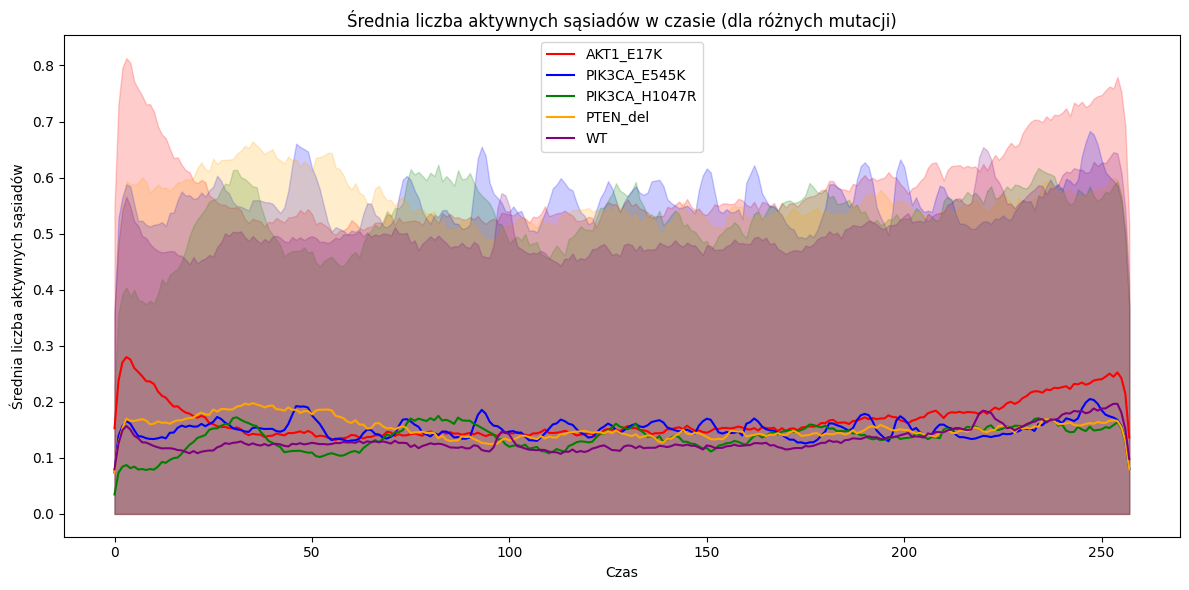

In [ ]:
# WYKRES ŚREDNIEJ LICZBY AKTYWNYCH SĄSIADÓW W CZASIE

df_avg = (
    file
    .groupby(['Mutation', 'Image_Metadata_T'])
    .agg(mean_neighbors=('Active_Neighbours', 'mean'),
         std_neighbors=('Active_Neighbours', 'std'))
    .reset_index()
)

# Przygotowanie wykresu
plt.figure(figsize=(12, 6))

for i, mut in enumerate(mutacje):
    
    # Filtrowanie danych dla jednej mutacji
    mutation_data = df_avg[df_avg['Mutation'] == mut]

    # Wykres średniej liczby aktywnych sąsiadów
    plt.plot(mutation_data['Image_Metadata_T'], mutation_data['mean_neighbors'], label=mut, color=colors[i])

    # Wykres zakresu błędu (odchylenie standardowe ograniczone z dołu przez 0)
    lower_bound = np.maximum(0, mutation_data['mean_neighbors'] - mutation_data['std_neighbors'])
    plt.fill_between(mutation_data['Image_Metadata_T'],
                     lower_bound,  # Dolna granica
                     mutation_data['mean_neighbors'] + mutation_data['std_neighbors'],  # Górna granica
                     color=colors[i],  # Kolor odpowiadający mutacji
                     alpha=0.2)  # Ustawienie przezroczystości
    
plt.title('Średnia liczba aktywnych sąsiadów w czasie (dla różnych mutacji)')
plt.xlabel('Czas')
plt.ylabel('Średnia liczba aktywnych sąsiadów')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# SPRAWDZENIE CZY LICZBA SĄSIADÓW SIĘ RÓŻNI W ZALEŻNOŚCI OD MUTACJI

# Zgrupowanie mean_neighbors według mutacji
groups = [
    group['mean_neighbors'].values
    for _, group in df_avg.groupby('Mutation')
]

# Test Kruskala–Wallisa
stat, p_value = kruskal(*groups)

print(f"P-wartość: {p_value}", p_value < 0.05)

P-wartość: 4.575993976959647e-65 True


In [9]:
# WYLICZENIE KOMÓREK STALE AKTYWNYCH (DO ZADANIA 3, ROBIONE TUTAJ, ŻEBY UWZGLĘDNIĆ NA WYKRESACH X-Y I GIFACH)

results = []

for (exp, site, cell_id), sub in file.groupby(['Exp_ID', 'Image_Metadata_Site', 'track_id']):
    sub = sub.copy()
    sub = sub.sort_values(by='Image_Metadata_T')

    sub['Is_active_10'] = False

    # Ciągi True o długości >=10
    current_streak = 0
    for i in sub.index:
        val=sub.at[i, 'Is_active']
        if val:
            current_streak += 1
        else:
            if current_streak >= 10:
                sub.loc[i-current_streak:i-1, 'Is_active_10'] = True
            current_streak = 0
        

    # Przypadek, gdy ciąg True kończy się na końcu dataframe
    if current_streak >= 10:
        sub.loc[sub.index[-1]-current_streak:, 'Is_active_10'] = True

    
    results.append(sub)

file = pd.concat(results)

print(file.head())

   Exp_ID  Image_Metadata_Site  track_id  Image_Metadata_T  Nuclear_size  \
0       1                    1         1                 0       303.000   
1       1                    1         1                 1       333.000   
2       1                    1         1                 2       314.000   
3       1                    1         1                 3       322.000   
4       1                    1         1                 4       313.999   

   ERKKTR_ratio  FoxO3A_ratio  objNuclei_Location_Center_X  \
0      0.704407       1.33383                      932.211   
1      0.848242       1.33791                      932.150   
2      1.059170       1.37627                      932.376   
3      1.188000       1.35754                      932.168   
4      1.205540       1.36695                      931.146   

   objNuclei_Location_Center_Y Mutation  Is_peak  Is_active  \
0                      875.248       WT    False      False   
1                      874.174       WT    F

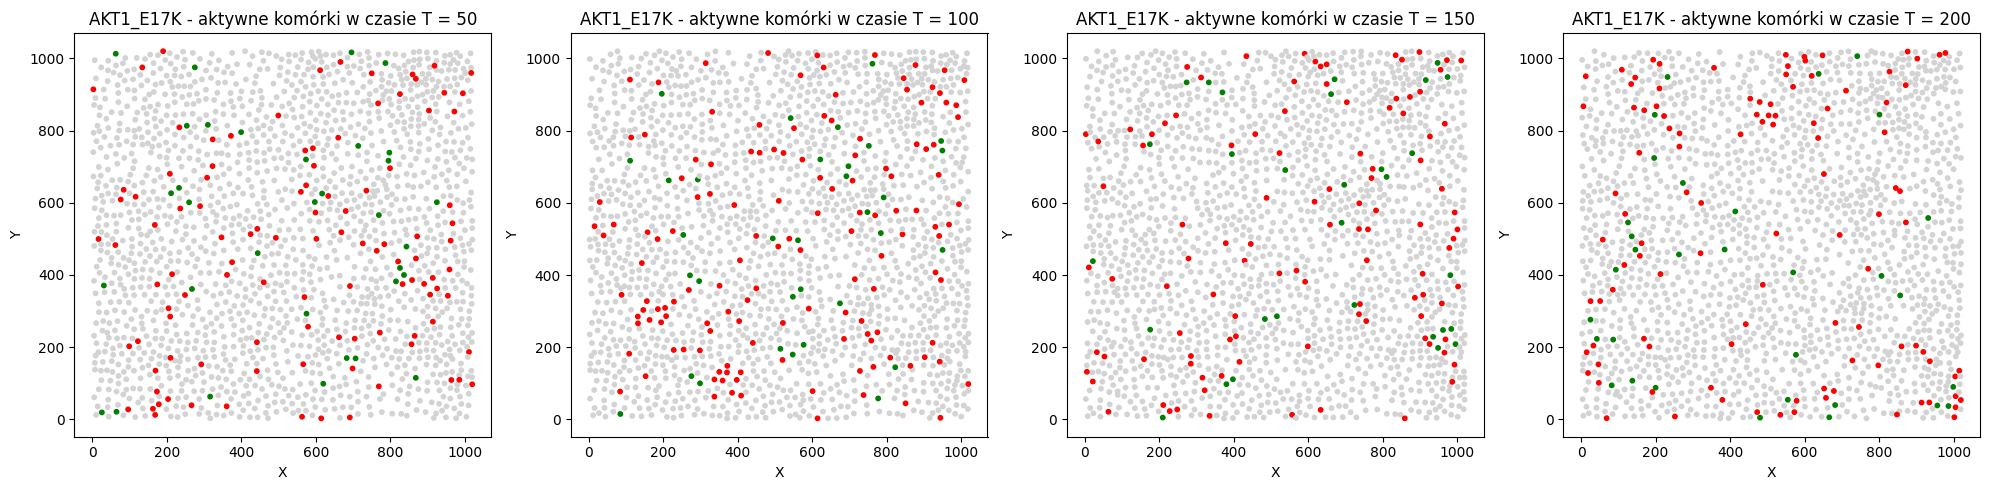

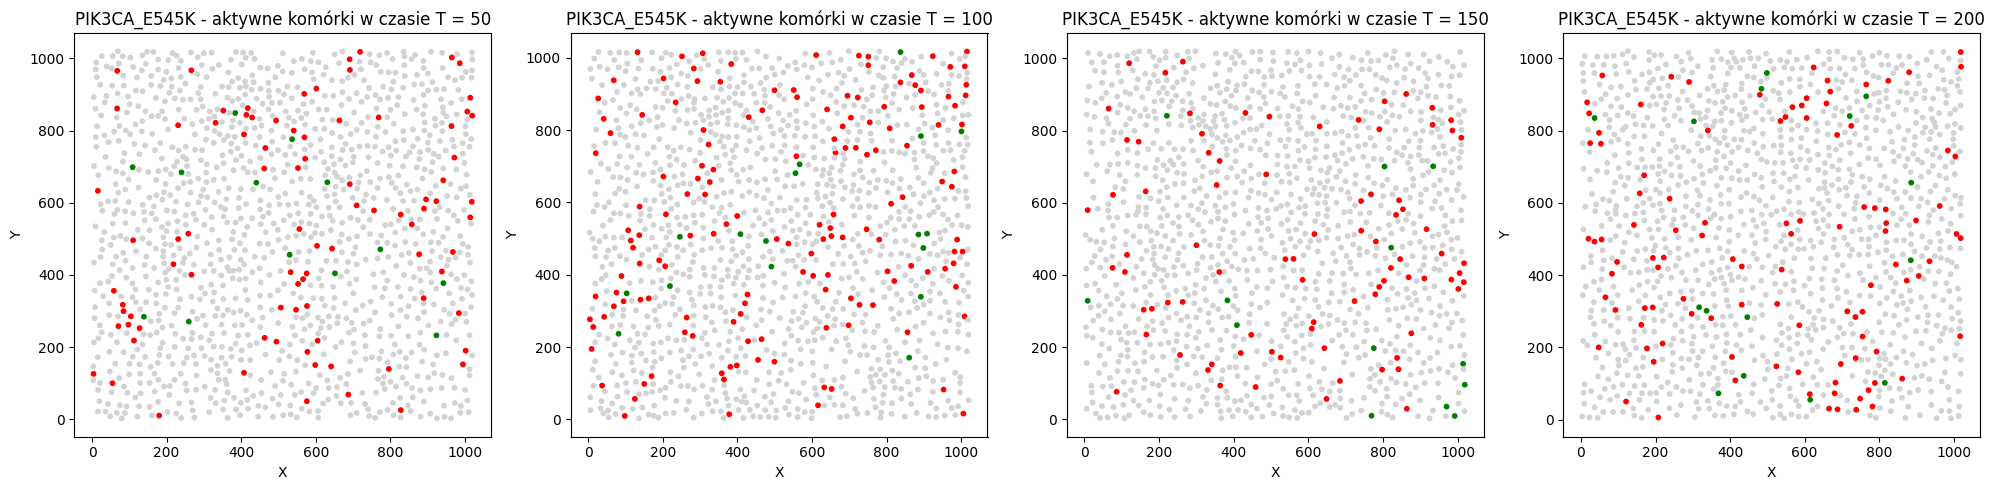

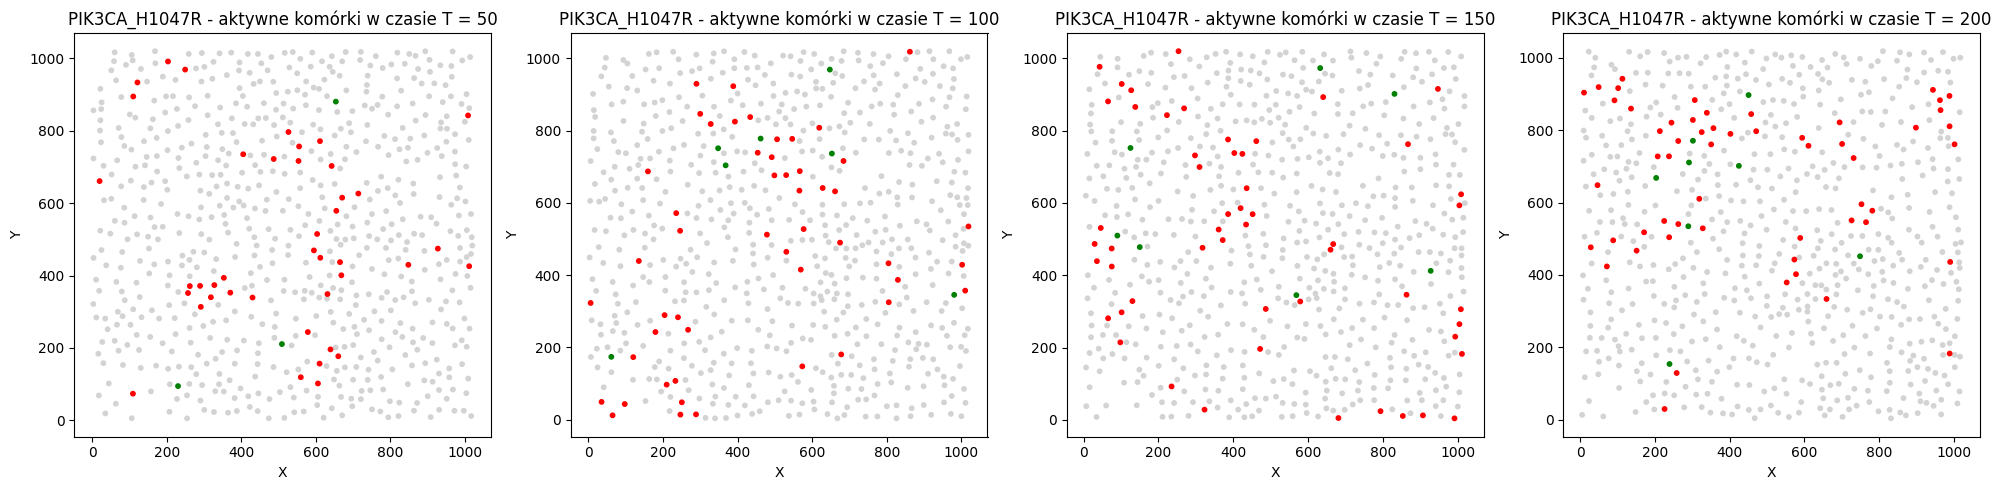

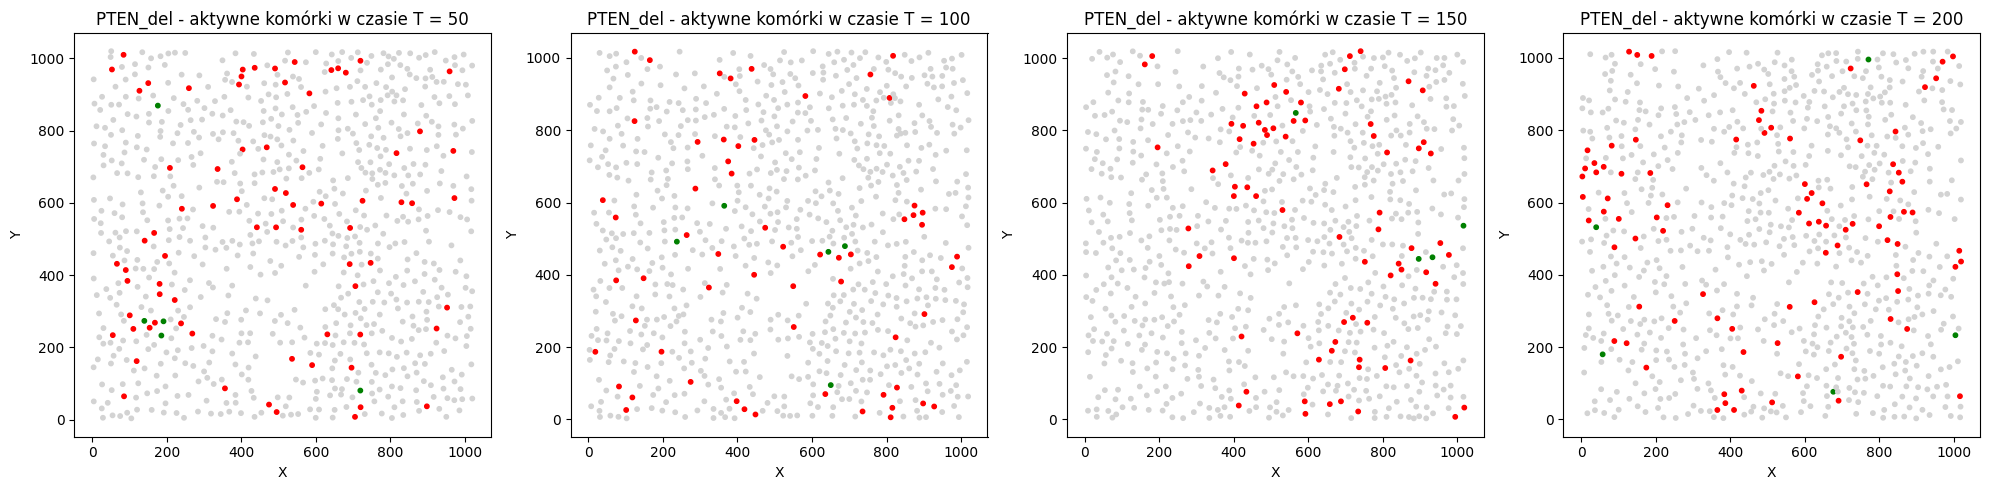

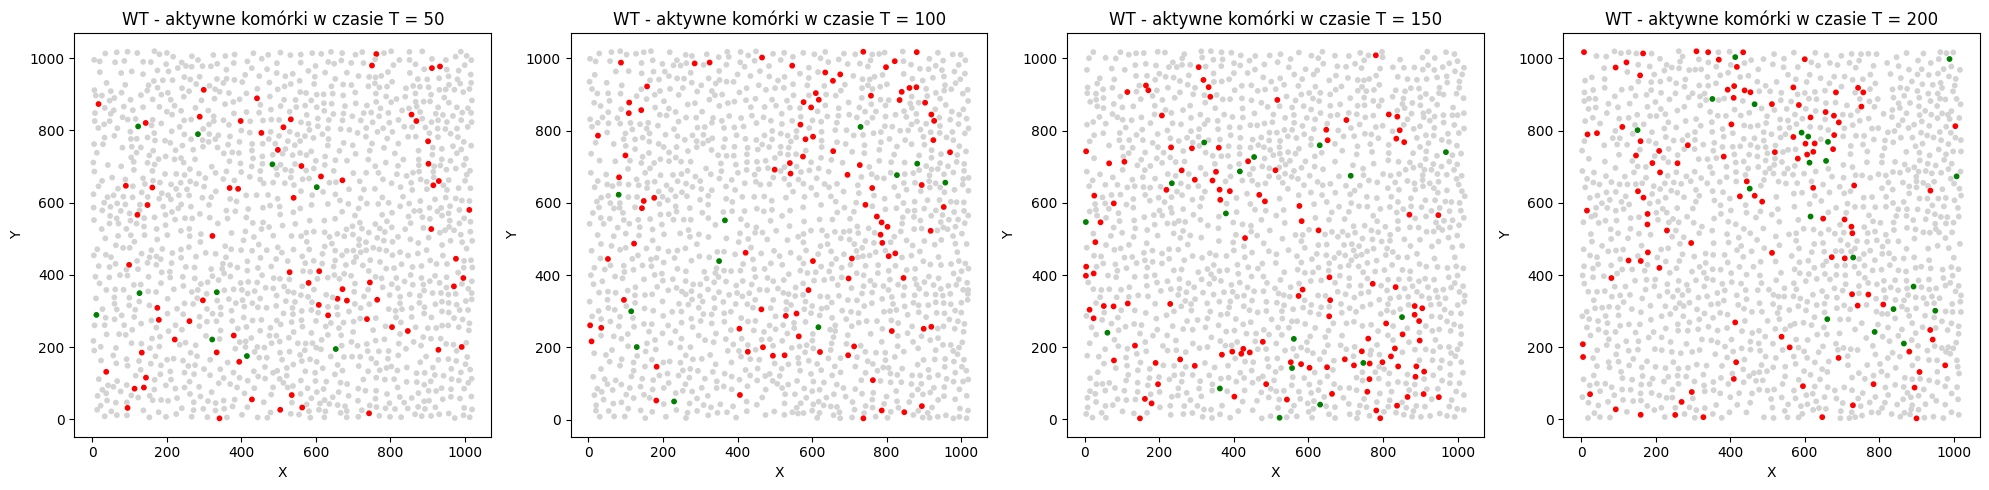

In [ ]:
# WIZUALIZACJE NA PRZESTRZENI X-Y

# wybranie czasów do wizualizacji
timepoints = [50, 100, 150, 200]

# Wybór danych dla eksperymentu 1
file_exp1=file[file['Exp_ID'] == 1]

for mutation in mutacje:
    fig, axes = plt.subplots(nrows=1, ncols=len(timepoints), figsize=(20, 5))
    for i, t in enumerate(timepoints):
        
        # Filtracja danych dla konkretnego czasu i mutacji
        ax = axes[i]
        sub = file_exp1[(file_exp1['Image_Metadata_T'] == t) & (file_exp1['Mutation'] == mutation)]

        # Wybór danych dla konkretnego site
        site=sub['Image_Metadata_Site'].values[0]
        sub=sub[sub['Image_Metadata_Site'] == site]
        
        # Rysowanie punktów dla aktywnych komórek

        colors = sub.apply(
        lambda row: 'green' if row['Is_active_10'] # jeśli ciągle aktywa to zielona
        else ('red' if row['Is_active'] else 'lightgray'), # jeśli aktywna to czerwona, jeśli nie to szara
        axis=1 
        )

        ax.scatter(
            sub['objNuclei_Location_Center_X'],
            sub['objNuclei_Location_Center_Y'],
            c=colors, # kolor aktywnych komórek
            s=10
        )
        ax.set_title(f'{mutation} - aktywne komórki w czasie T = {t}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    plt.tight_layout()
    plt.show()

In [ ]:
# TWORZENIE GIFÓW

# Kroki czasowe co 1 dla GIF
timepoints = list(range(50, 130))

# Przygotowanie folderu do zapisywania obrazów
output_dir = 'gif_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iteracja po mutacjach
for mutation in mutacje:
    # Lista do przechowywania ścieżek do zapisanych obrazów dla jednej mutacji
    image_paths = []

    # Iteracja po momentach czasowych
    for t in timepoints:
        sub = file_exp1[(file_exp1['Image_Metadata_T'] == t) & (file_exp1['Mutation'] == mutation)]

        # Wybór danych dla konkretnego site
        site=sub['Image_Metadata_Site'].values[0]
        sub=sub[sub['Image_Metadata_Site'] == site]

        colors = sub.apply(
        lambda row: 'green' if row['Is_active_10'] # Jeśli ciągle aktywa to zielona
        else ('red' if row['Is_active'] else 'lightgray'), # Jeśli aktywna to czerwona, jeśli nie to szara
        axis=1 
        )

        # Tworzenie wykresu
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(
            sub['objNuclei_Location_Center_X'],
            sub['objNuclei_Location_Center_Y'],
            c=colors,
            s=10
        )
        ax.set_title(f'{mutation} - aktywne komórki w czasie T = {t}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        image_path = f'{output_dir}/{mutation}_T{t}.png'
        fig.savefig(image_path)
        plt.close(fig)  # Zamykamy konkretną figurę, nic się nie wypisuje
        
        # Dodaj ścieżkę do listy obrazów
        image_paths.append(image_path)

    # Tworzenie GIF z zapisanych obrazów dla danej mutacji
    gif_filename = f'activity_animation_{mutation}.gif'
    with imageio.get_writer(gif_filename, mode='I', duration=0.9) as writer:
        for image_path in image_paths:
            image = imageio.imread(image_path)
            writer.append_data(image)

    # Usuwanie obrazów po stworzeniu GIF
    for image_path in image_paths:
        os.remove(image_path)

    print(f'GIF dla mutacji {mutation} został zapisany jako {gif_filename}')

C:\Users\agnie\AppData\Local\Temp\ipykernel_10260\1732297237.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


GIF dla mutacji AKT1_E17K został zapisany jako activity_animation_AKT1_E17K.gif
GIF dla mutacji PIK3CA_E545K został zapisany jako activity_animation_PIK3CA_E545K.gif
GIF dla mutacji PIK3CA_H1047R został zapisany jako activity_animation_PIK3CA_H1047R.gif
GIF dla mutacji PTEN_del został zapisany jako activity_animation_PTEN_del.gif
GIF dla mutacji WT został zapisany jako activity_animation_WT.gif


### ZADANIE 3

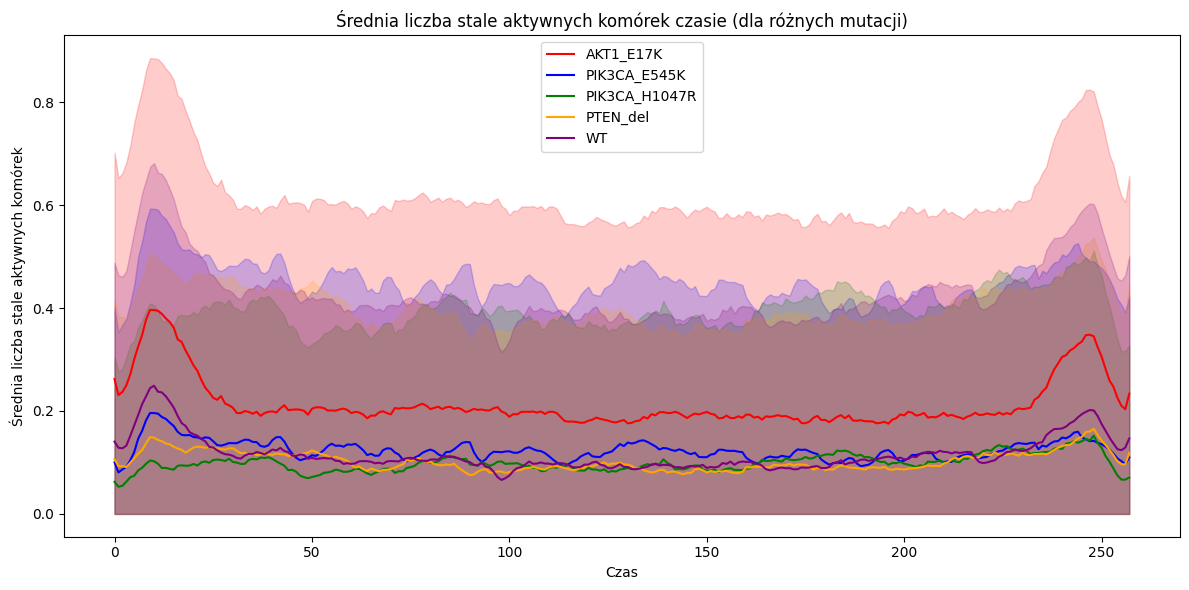

In [11]:
# WYKRES ŚREDNIEJ LICZBY STALE AKTYWNYCH KOMÓREK W CZASIE

colors = ['red', 'blue', 'green', 'orange', 'purple']

# tylko komórki aktywne
active10=file[file['Is_active'] == True]

active10_groupby = (
    active10
    .groupby(['Mutation', 'Image_Metadata_T'])
    .agg(mean_active10=('Is_active_10', 'mean'),
         std_active10=('Is_active_10', 'std'))
    .reset_index()
)

# Przygotowanie wykresu
plt.figure(figsize=(12, 6))

for i, mutation in enumerate(mutacje):
    
    # Filtrujemy dane dla jednej mutacji
    mutation_data = active10_groupby[active10_groupby['Mutation'] == mutation]

    # Wykres średniej liczby dtale aktywnych komórek
    plt.plot(mutation_data['Image_Metadata_T'], mutation_data['mean_active10'], label=mutation, color=colors[i])

    # Wykres zakresu błędu (odchylenie standardowe ograniczone z dołu przez 0)
    lower_bound = np.maximum(0, mutation_data['mean_active10'] - mutation_data['std_active10'])
    plt.fill_between(mutation_data['Image_Metadata_T'],
                     lower_bound,  # Dolna granica
                     mutation_data['mean_active10'] + mutation_data['std_active10'],  # Górna granica
                     alpha=0.2, color=colors[i])  # Ustawienie przezroczystości
    
plt.title('Średnia liczba stale aktywnych komórek czasie (dla różnych mutacji)')
plt.xlabel('Czas')
plt.ylabel('Średnia liczba stale aktywnych komórek')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# TEST MANN-WHITNEYA DLA STALE AKTYWNYCH KOMÓREK W CZASIE 60-180

wyniki = []

# Czas 60-180
active10_groupby = active10_groupby[(active10_groupby['Image_Metadata_T']>=60) & (active10_groupby['Image_Metadata_T']<=180)]

for mut in mutacje_WT:

    grupa_wt = active10_groupby[active10_groupby['Mutation'] == 'WT']['mean_active10']
    grupa_mut = active10_groupby[active10_groupby['Mutation'] == mut]['mean_active10']

    # Test Manna-Whitneya
    stat, p = mannwhitneyu(grupa_mut, grupa_wt, alternative='two-sided')

    # Porównanie średnich aktywności w celu określenia zmiany
    srednia_wt = grupa_wt.mean()
    srednia_mut = grupa_mut.mean()
    
    if srednia_mut > srednia_wt:
        zmiana = "wzrost"
    elif srednia_mut < srednia_wt:
        zmiana = "spadek"
    else:
        zmiana = "brak zmiany"

    wyniki.append({'Mutacja': mut, 'p_raw': p, 'U': stat, 'Zmiana': zmiana})

# Do DataFrame
wyniki_df = pd.DataFrame(wyniki)

# Korekcja wielokrotnych porównań (Bonferroni)
p_skorygowane = multipletests(wyniki_df['p_raw'], method='bonferroni')[1]
wyniki_df['p_bonferroni'] = p_skorygowane
wyniki_df['Istotne (α=0.05)'] = wyniki_df['p_bonferroni'] < 0.05

print(wyniki_df)
wyniki_df.to_csv('wyniki_testu_mann_whitneya_stale_aktywne.csv', index=False)

         Mutacja         p_raw        U  Zmiana  p_bonferroni  \
0      AKT1_E17K  3.360344e-41  14641.0  wzrost  1.344137e-40   
1   PIK3CA_E545K  2.021180e-35  14084.0  wzrost  8.084720e-35   
2  PIK3CA_H1047R  3.064777e-02   6143.0  spadek  1.225911e-01   
3       PTEN_del  1.247578e-10   3817.0  spadek  4.990312e-10   

   Istotne (α=0.05)  
0              True  
1              True  
2             False  
3              True  


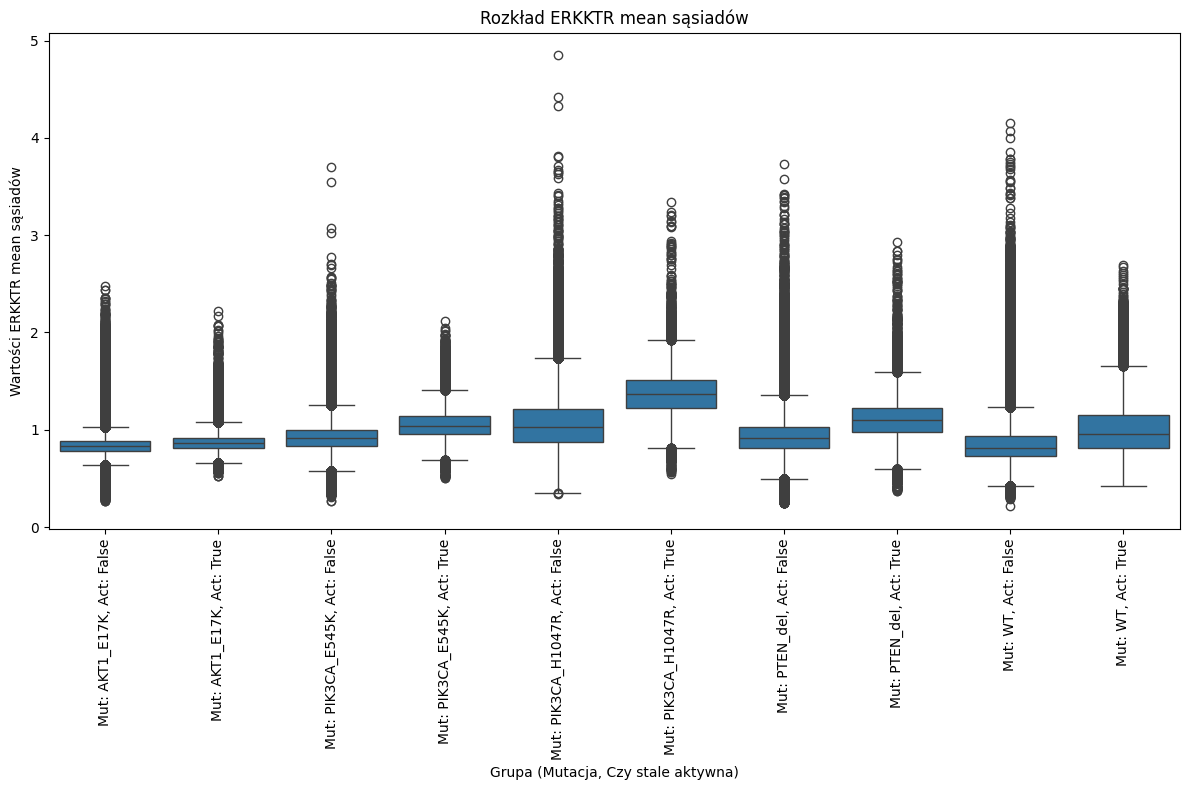

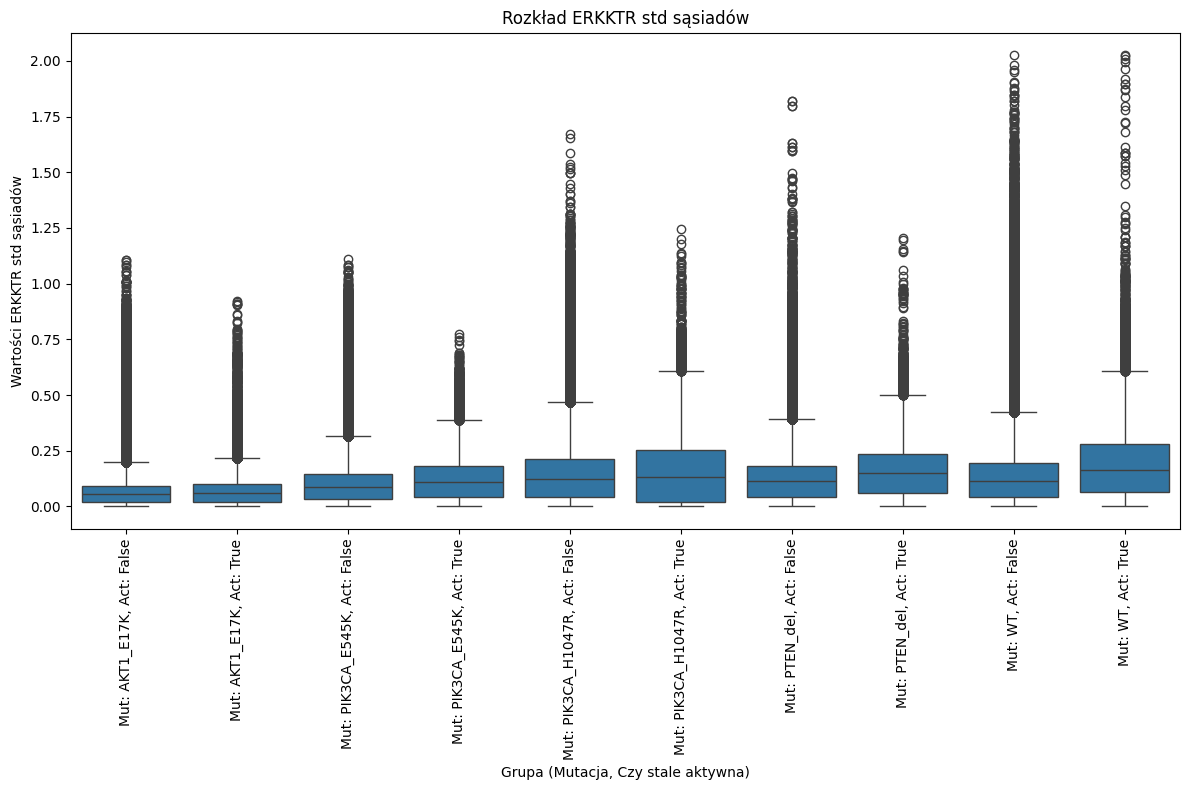

In [ ]:
# BOXPLOTY ŚREDNIEJ I STD AKTYWNOŚCI SĄSIADÓW DLA KOMÓREK STALE AKTYWNYCH I NIEAKTYWNYCH

for statistic in ['mean', 'std']:
    # Przygotowanie danych do boxplotów
    boxplot_data = []
    group_labels = []

    column = 'Neighbours_ERKKTR_' + statistic

    for (mutation, is_active), sub in file.groupby(['Mutation', 'Is_active_10']):

        # Dodanie wartości ERKKTR sąsiadów do listy danych
        boxplot_data.extend(sub[column].values)
        group_labels.extend([f"Mut: {mutation}, Act: {is_active}"] * len(sub[column].values))

    boxplot_df = pd.DataFrame({'ERKKTR_' + statistic: boxplot_data, 'Group': group_labels})

    # Tworzenie boxplotów
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Group', y='ERKKTR_' + statistic, data=boxplot_df)
    plt.title('Rozkład ERKKTR ' + statistic +  ' sąsiadów')
    plt.xlabel('Grupa (Mutacja, Czy stale aktywna)')
    plt.ylabel('Wartości ERKKTR ' + statistic + ' sąsiadów')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [18]:
# PORÓWNANIE ŚREDNIEJ I ODCHYLENIA STANDARDOWEGO AKTYWNOŚCI SĄSIADÓW DLA KOMÓREK STALE AKTYWNYCH W CZASIE 60-180

# Czas 60-180
activity10 = file[(file['Image_Metadata_T']>=60) & (file['Image_Metadata_T']<=180)]

for statistic in ['mean', 'std']:

    wyniki = []

    for mut in mutacje:
        sub = activity10[activity10['Mutation'] == mut]

        if statistic == 'mean':
            sub_true = sub[sub['Is_active_10'] == True]['Neighbours_ERKKTR_mean']
            sub_false = sub[sub['Is_active_10'] == False]['Neighbours_ERKKTR_mean']
        elif statistic == 'std':
            sub_true = sub[sub['Is_active_10'] == True]['Neighbours_ERKKTR_std']
            sub_false = sub[sub['Is_active_10'] == False]['Neighbours_ERKKTR_std']


        # Test Manna-Whitneya
        stat, p = mannwhitneyu(sub_true, sub_false, alternative='two-sided')

        # Porównanie średnich aktywności w celu określenia zmiany
        srednia_true = sub_true.mean()
        srednia_false = sub_false.mean()

        
        if srednia_true > srednia_false:
            zmiana = "wzrost"
        elif srednia_true < srednia_false:
            zmiana = "spadek"
        else:
            zmiana = "brak zmiany"

        wyniki.append({'Mutacja': mut, 'p_raw': p, 'U': stat, 'Zmiana': zmiana})

    # Do DataFrame
    wyniki_df = pd.DataFrame(wyniki)

    # Korekcja wielokrotnych porównań (Bonferroni)
    p_skorygowane = multipletests(wyniki_df['p_raw'], method='bonferroni')[1]
    wyniki_df['p_bonferroni'] = p_skorygowane
    wyniki_df['Istotne (α=0.05)'] = wyniki_df['p_bonferroni'] < 0.05

    print(statistic)
    print(wyniki_df)
    wyniki_df.to_csv(f'wyniki_testu_mann_whitneya_stale_aktywne_{statistic}.csv', index=False)


mean
         Mutacja  p_raw             U  Zmiana  p_bonferroni  Istotne (α=0.05)
0      AKT1_E17K    0.0  1.635186e+11  wzrost           0.0              True
1   PIK3CA_E545K    0.0  1.249686e+11  wzrost           0.0              True
2  PIK3CA_H1047R    0.0  3.409398e+10  wzrost           0.0              True
3       PTEN_del    0.0  4.164248e+10  wzrost           0.0              True
4             WT    0.0  7.051297e+10  wzrost           0.0              True
std
         Mutacja         p_raw             U  Zmiana  p_bonferroni  \
0      AKT1_E17K  2.707029e-15  1.344740e+11  wzrost  1.353515e-14   
1   PIK3CA_E545K  0.000000e+00  9.172553e+10  wzrost  0.000000e+00   
2  PIK3CA_H1047R  5.907969e-19  2.126034e+10  wzrost  2.953985e-18   
3       PTEN_del  0.000000e+00  3.176420e+10  wzrost  0.000000e+00   
4             WT  0.000000e+00  5.777880e+10  wzrost  0.000000e+00   

   Istotne (α=0.05)  
0              True  
1              True  
2              True  
3             